In [17]:
import os
import glob
from pathlib import Path

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader

import numpy as np
import IPython.display as display
from collections import Counter
import matplotlib.pyplot as plt

In [15]:
# Fix seed
SEED = 42
np.random.seed(seed=SEED)

ESC-50: Dataset for Environmental Sound Classification <br>
https://github.com/karolpiczak/ESC-50 <br>
Clone this repositiry somewhere and specify path to the dataset below.


In [2]:
DATASET_PATH = './../ESC-50/audio'
DEVICE = 'cpu'
BATCH_SIZE = 64


# Naive approach: 1D CNN

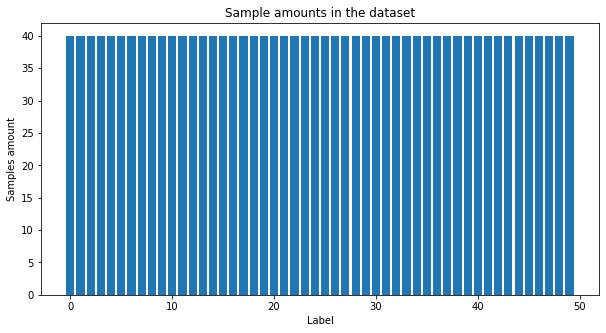

In [3]:
# get complete file path
filenames = glob.glob(os.path.join(DATASET_PATH, '*.wav'))

# extracht sound labels and count them
labels = [int(item.split('-')[-1].replace('.wav', '')) for item in filenames]
sorted_labels_amount = dict(sorted(Counter(labels).items(), key=lambda x: x[0]))

# plot result
plt.figure(figsize=(10, 5))
plt.bar(x=sorted_labels_amount.keys(), height=sorted_labels_amount.values())
plt.title('Sample amounts in the dataset')
plt.xlabel('Label')
plt.ylabel('Samples amount')
plt.show()

Every category distributed equally 👌



In [4]:
# Get random sound sample
random_name = np.random.choice(filenames)
display.Audio(random_name)


### Create data generator

In [50]:
class ESC50(Dataset):
    def __init__(self, dataset_path, subset_name=None):
        # Create generator with .wav file pathes
        files = Path(dataset_path).glob('*.wav')
        
        # Set dataset type dict
        subset_type = {1: 'train',
                       2: 'train',
                       3: 'train',
                       4: 'valid',
                       5: 'test'}
        
        # Iterate through file path and get list of (file path, label)
        # File name example: 5-198278-B-7.wav'
        extract_label = lambda x: int(x.split('-')[-1].replace('.wav', ''))
#         extract_dataset_type = lambda x: int(x.split('/')[-1][0]) # 1, 2, 3 - train; 4 - valid; 5 - test
        
        self.items = [(str(f_path), extract_label(f_path.name)) for f_path in files \
                      if subset_name == subset_type[int(f_path.name[0])]]
        # Get length of items list
        self.length = len(self.items)
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, _ = torchaudio.load(filename)
        return (audio_tensor, label)
    
    def __len__(self):
        return self.length

In [51]:
train_loader = DataLoader(ESC50(DATASET_PATH, subset_name='train'), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(ESC50(DATASET_PATH, subset_name='valid'), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ESC50(DATASET_PATH, subset_name='test'), batch_size=BATCH_SIZE, shuffle=True)

### Simple AudioNet CNN

In [53]:
# next(iter(train_loader))